# Spectrum Model applied to a FRED dataset

The following basically follows the analysis given in Section 6.4 of the book "Time Series Analysis" by James D. Hamilton (this is widely recognized as a classic textbook on time series).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cvxpy as cp
from scipy.signal import find_peaks

The following datset is FRED's "Industrial Production: Total Index" dataset. It is a monthly dataset that is **not** seasonally adjusted. 

  observation_date  IPB50001N
0       1919-01-01     4.7841
1       1919-02-01     4.5959
2       1919-03-01     4.4884
3       1919-04-01     4.5691
4       1919-05-01     4.7035
5       1919-06-01     4.9991
6       1919-07-01     5.1604
7       1919-08-01     5.2679
8       1919-09-01     5.2947
9       1919-10-01     5.2679


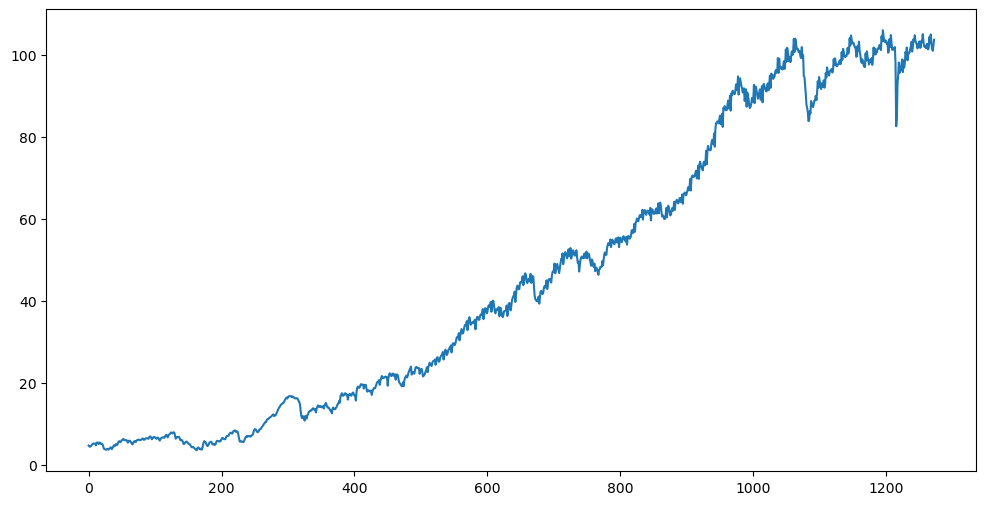

In [2]:
prod_index = pd.read_csv("IPB50001N-06March2025FRED.csv")
print(prod_index.head(10))

pind = prod_index['IPB50001N']
plt.figure(figsize = (12, 6))
plt.plot(pind)
plt.show()

Instead of working with the index data directly, we want to work with the monthly growth rate of the index. This is defined by: 
\begin{equation*}
   y_t = 100 \left(\log I_t - \log I_{t-1} \right)
\end{equation*}
where $I_t$ is the index value at time $t$. Why does this definition correspond to the growth rate?

1272


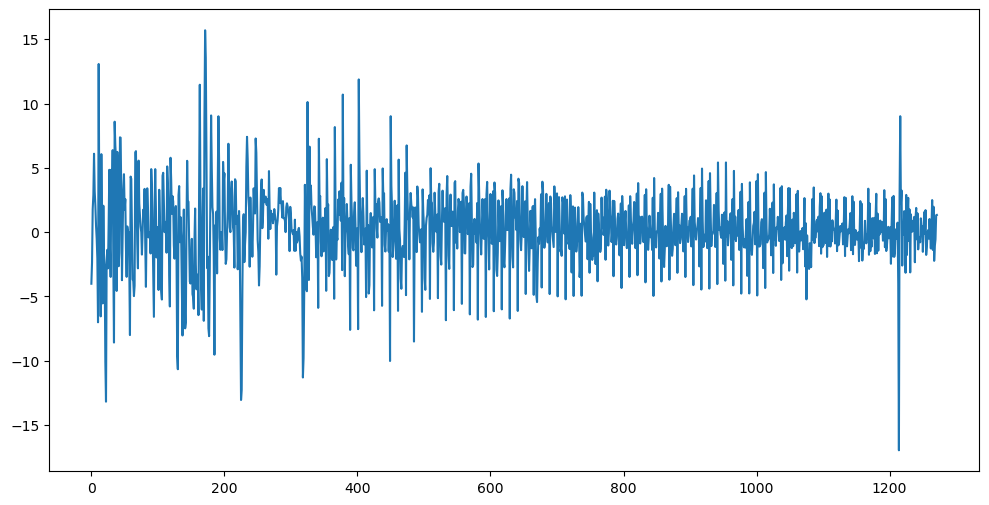

In [3]:
y = 100 * np.diff(np.log(pind))
n = len(y)
print(n)

plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()

We want to fit the spectrum model to this dataset. Since the data size is even ($n = 1272$), the spectrum model is given by: 
\begin{equation*}
    y_t = \beta_0 + \sum_{j=1}^m \left( \beta_{1j} \cos(2 \pi (j/n) t) + \beta_{2j} \sin(2 \pi (j/n) t) \right) + \beta_{m+1} \cos(\pi t). 
\end{equation*}
where $m = (n/2) - 1$ (the presence of the $\cos(\pi t)$ term at the end makes this slightly different from the model when $n$ is odd), along with 
\begin{equation*}
   \beta_{1j}, \beta_{2j} \overset{\text{i.i.d}}{\sim} N(0, \tau_j^2) ~~~ \text{ and } ~~~ \beta_{m+1} \sim N(0, \tau_{m+1}^2).
\end{equation*}

Observe first that
\begin{equation*}
   \beta_0 = \bar{y}, ~~~ \beta_{1j} = \frac{2}{n} \sum_{t=1}^n y_t \cos(2 \pi (j/n) t), ~~~ \beta_{2j} = \frac{2}{n} \sum_{t=1}^n y_t \sin(2 \pi (j/n) t), ~~~ \beta_{m+1} = \frac{1}{n} \sum_{t=1}^n y_t \cos(\pi t).
\end{equation*}
Recall that $\sum_{t=1}^n y_t \cos(2 \pi (k/n) t)$ is the real part and $\sum_{t=1}^n y_t \sin(2 \pi (k/n) t)$ is the imaginary part of the DFT term $b_k$. Thus the model can be alternatively be written in terms of DFT as: 
\begin{equation*}
  Re(b_j), Im(b_j) \overset{\text{i.i.d}}{\sim} N(0, n^2 \tau_j^2/4) ~~~ \text{ and }~~~  b_{m+1} = b_{n/2} \sim N(0, \tau_{m+1}^2 n^2).  
\end{equation*}
We also have
\begin{equation*}
   |b_j|^2 \sim \frac{n^2 \tau_j^2}{4} \chi^2_2 ~~ \text{ for } j = 1, \dots, m ~~ \text{ and } ~~~ b_{m+1}^2 \sim n^2 \tau_{m+1}^2 \chi^2_1
\end{equation*}
In terms of the periodogram, we have
\begin{equation*}
   I(j/n) = \frac{|b_j|^2}{n} \sim \frac{n \tau_j^2}{4} \chi^2_2 ~~ \text{ for } j = 1, \dots, m ~~ \text{ and } ~~~ I(1/2) = \frac{b_{m+1}^2}{n} \sim n \tau_{m+1}^2 \chi^2_1
\end{equation*}
The likelihood of the periodogram is then given by (up to constant)
\begin{equation*}
   \left(\prod_{j=1}^m \frac{1}{\tau_j^2} \right) \frac{1}{\tau_{m+1}} \exp \left(-\frac{2}{n} \sum_{j=1}^m \frac{I(j/n)}{\tau_j^2} - \frac{I(1/2)}{2n\tau^2_{m+1}}\right)
\end{equation*}
which implies that the negative log-likelihood is
\begin{equation*}
   \frac{2}{n} \sum_{j=1}^m \frac{I(j/n)}{\tau_j^2} + \frac{I(1/2)}{2n \tau_{m+1}^2} + 2 \sum_{j=1}^m \log \tau_j + \log \tau_{m+1}
\end{equation*}
Writing $\tau_j = e^{\alpha_j}$ or equivalently $\alpha_j = \log \tau_j$, we can rewrite the log-likelihood as
\begin{equation*}
    \frac{2}{n} \sum_{j=1}^m I(j/n) e^{-2\alpha_j} + \frac{1}{2n} I(1/2) e^{-2\alpha_{m+1}} + 2 \sum_{j=1}^m \alpha_j + \alpha_{m+1}.
\end{equation*}

Minimizing the above without regularization leads to
\begin{equation*}
   \alpha_j = \log \sqrt{\frac{2I(j/n)}{n}} ~~ \text{ for } j = 1, \dots, m ~~ \text{ and }~~ \alpha_{m+1} = \log \sqrt{\frac{I(1/2)}{n}}.
\end{equation*}
We therefore minimize the following: 
\begin{equation*}
    \frac{2}{n} \sum_{j=1}^m I(j/n) e^{-2\alpha_j} + \frac{1}{2n} I(1/2) e^{-2\alpha_{m+1}} + 2 \sum_{j=1}^m \alpha_j + \alpha_{m+1} + \lambda \sum_{j=2}^{m-1} \left((\alpha_{j+1} - \alpha_j) - (\alpha_j - \alpha_{j-1}) \right)^2
\end{equation*}
or
\begin{equation*}
    \frac{2}{n} \sum_{j=1}^m I(j/n) e^{-2\alpha_j} + \frac{1}{2n} I(1/2) e^{-2\alpha_{m+1}} + 2 \sum_{j=1}^m \alpha_j + \alpha_{m+1} + \lambda \sum_{j=2}^{m-1} \left|(\alpha_{j+1} - \alpha_j) - (\alpha_j - \alpha_{j-1}) \right|.
\end{equation*}
Note that we are not including $\alpha_{m+1}$ in the penalty. 

In [4]:
def periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)
    fourier_freqs = np.arange(1/n, (1/2) + (1/n), 1/n) 
    # we are now including 1/2 in the set of Fourier frequencies
    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m + 1]) ** 2) / n

    return fourier_freqs, pgram_y

In [5]:
def periodogram(y):
    fft_y = np.fft.fft(y)
    n = len(y)

    if n % 2 == 0: # even n
        fourier_freqs = np.arange(1/n, (1/2) + (1/n), 1/n)  # Includes 1/2
    else:  # odd n
        fourier_freqs = np.arange(1/n, 1/2, 1/n)  # Excludes 1/2

    m = len(fourier_freqs)
    pgram_y = (np.abs(fft_y[1:m + 1]) ** 2) / n

    return fourier_freqs, pgram_y

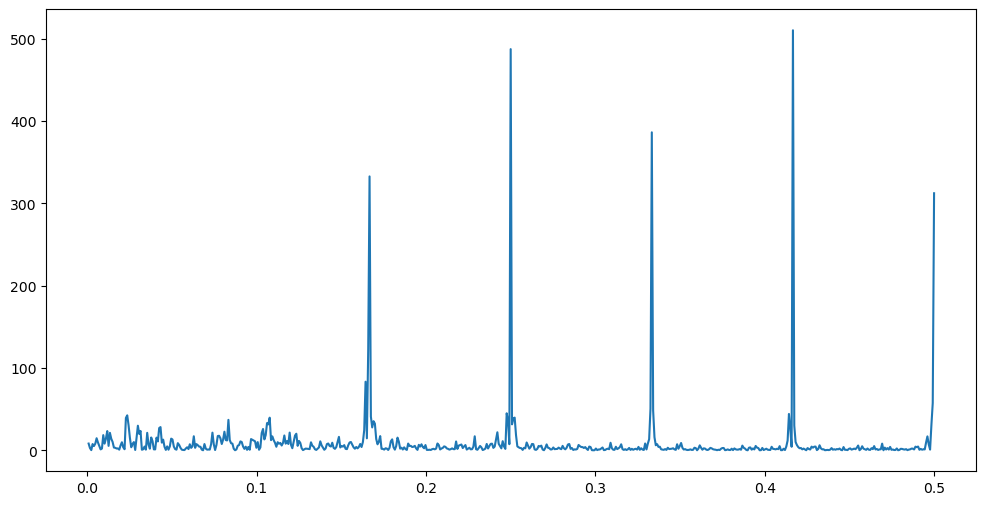

In [6]:
freq, pgram = periodogram(y)

plt.figure(figsize = (12, 6))
#plt.plot(freq, np.log(pgram))
plt.plot(freq, pgram)
plt.show()

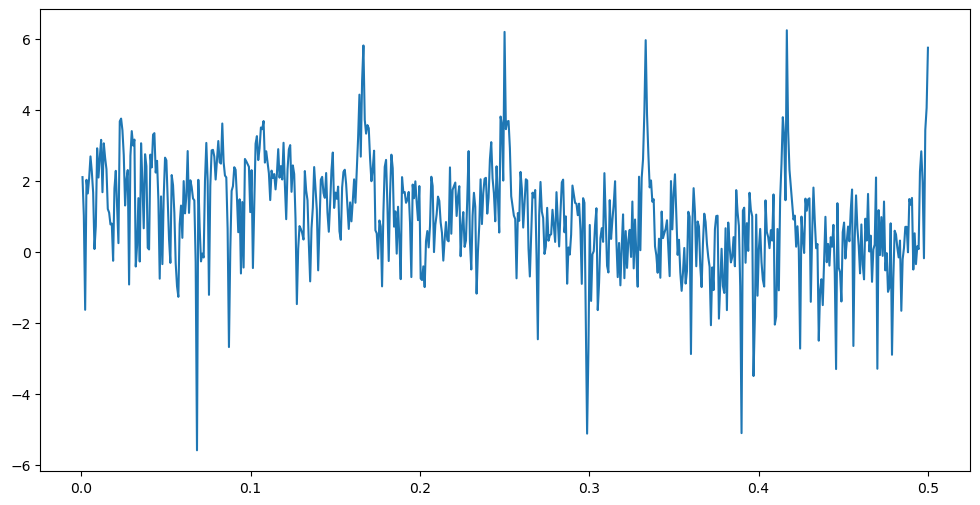

In [7]:
plt.figure(figsize = (12, 6))
plt.plot(freq, np.log(pgram))
plt.show()

What can be interpreted from the periodogram? The big peaks probably correspond to seasonal effects (this is a monthly dataset). Is there any information in the initial part of the periodogram. In these kinds of datasets, one often looks for evidence of "business cycles". Is it obvious to find such evidence from the periodogram?

In [8]:
def spectrum_n_even_estimator_ridge(y, lambda_val):
    freq, I = periodogram(y)
    n = len(y) # Length of original time series (assumed to be even here)
    m = (n // 2) - 1

    alpha = cp.Variable(n // 2)
    
    I_1_to_m = I[0:(m - 1)]
    I_m_plus_1 = I[m]

    neg_likelihood_term_1_to_m = cp.sum(cp.multiply((2 * I_1_to_m / n), cp.exp(-2 * alpha[0:(m - 1)])) + 2 * alpha[0:(m - 1)])
    neg_likelihood_term_m_plus_1 = cp.multiply((I_m_plus_1 / (2 * n)), cp.exp(-2 * alpha[m])) + alpha[m]
    neg_likelihood_term = neg_likelihood_term_1_to_m + neg_likelihood_term_m_plus_1

    smoothness_penalty = cp.sum(cp.square(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))

    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve()

    return alpha.value, freq


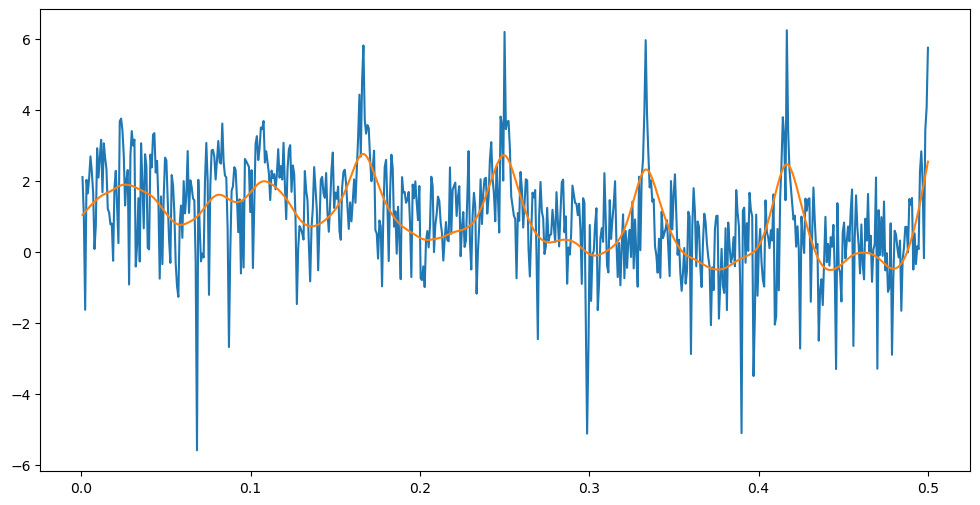

In [ ]:
alpha_opt_ridge, freq = spectrum_n_even_estimator_ridge(y, 5000)
# I found lambda = 5000 is reasonable here
# Below we plot the log(periodogram) and the fitted spectrum estimator on the same plot
# This illustrates how the spectrum estimate can be viewed as a smoothing of the periodogram

plt.figure(figsize = (12, 6))
plt.plot(freq, np.log(pgram))
plt.plot(freq, np.log(n / 2) + 2 * alpha_opt_ridge)
plt.show()

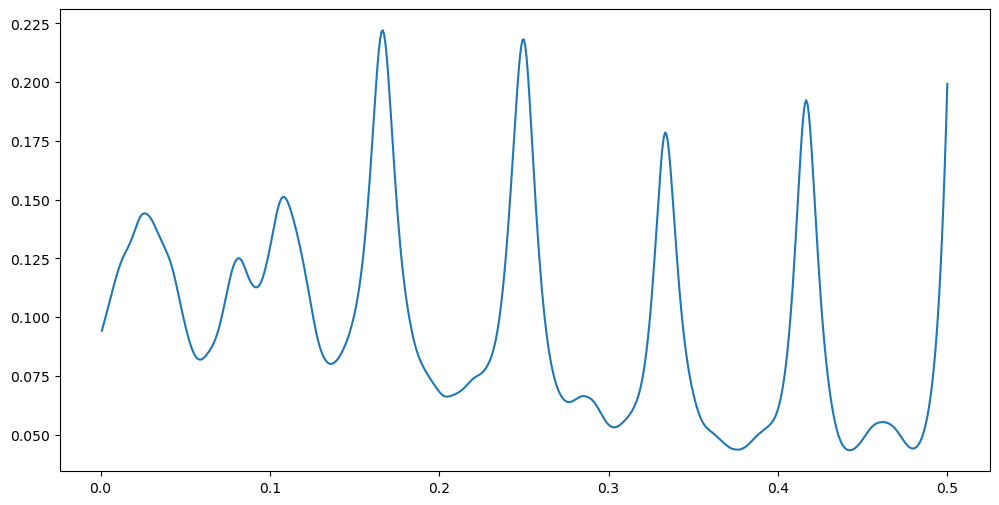

In [10]:
# Plotting the tau_j estimates (estimated spectrum):
tau_opt_ridge = np.exp(alpha_opt_ridge)

plt.figure(figsize = (12, 6))
plt.plot(freq, tau_opt_ridge)
plt.show()

In [11]:
def spectrum_n_even_estimator_lasso(y, lambda_val):
    freq, I = periodogram(y)
    n = len(y) # Length of original time series (assumed to be even here)
    m = (n // 2) - 1

    alpha = cp.Variable(n // 2)

    I_1_to_m = I[0:(m - 1)]
    I_m_plus_1 = I[m]

    neg_likelihood_term_1_to_m = cp.sum(cp.multiply((2 * I_1_to_m / n), cp.exp(-2 * alpha[0:(m - 1)])) + 2 * alpha[0:(m - 1)])
    neg_likelihood_term_m_plus_1 = cp.multiply((I_m_plus_1 / (2 * n)), cp.exp(-2 * alpha[m])) + alpha[m]
    neg_likelihood_term = neg_likelihood_term_1_to_m + neg_likelihood_term_m_plus_1

    smoothness_penalty = cp.sum(cp.abs(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))

    objective = cp.Minimize(neg_likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve()

    return alpha.value, freq 

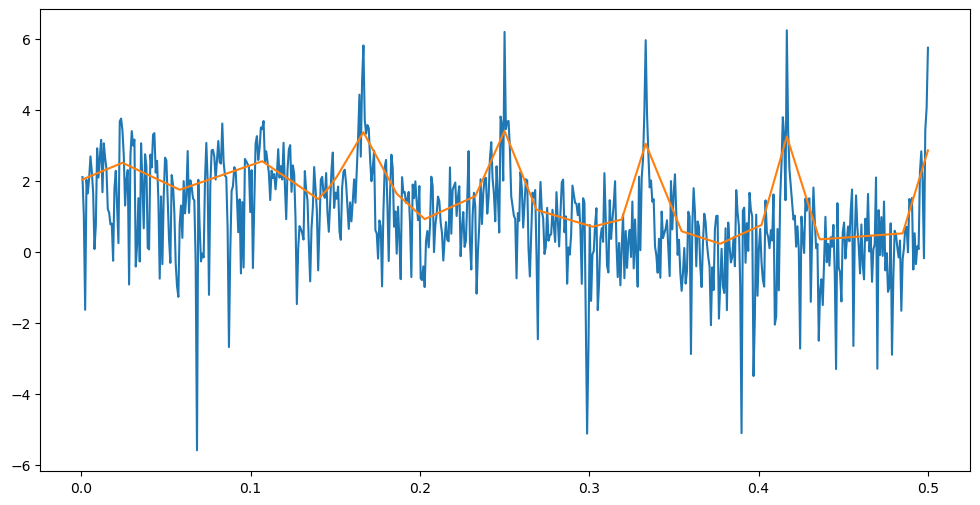

In [12]:
alpha_opt_lasso, freq = spectrum_n_even_estimator_lasso(y, 100)
# I found lambda = 100 is reasonable here
# Below we plot the log(periodogram) and the fitted spectrum estimator on the same plot
# This illustrates how the spectrum estimate can be viewed as a smoothing of the periodogram

plt.figure(figsize = (12, 6))
plt.plot(freq, np.log(pgram))
plt.plot(freq, np.log(n / 2) + 2 * alpha_opt_lasso)
plt.show()

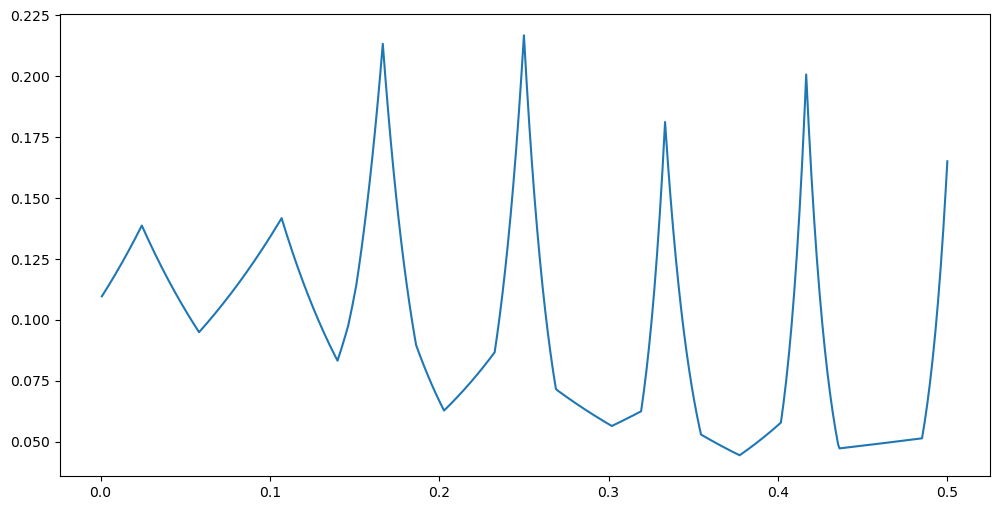

In [13]:
# Plotting the tau_j estimates (estimated spectrum):
tau_opt_lasso = np.exp(alpha_opt_lasso)

plt.figure(figsize = (12, 6))
plt.plot(freq, tau_opt_lasso)
plt.show()

In both the estimates above, the first peak in the estimated spectrum corresponds to 

In [14]:
# Find peaks in the estimated spectrum
peaks_ridge, _ = find_peaks(tau_opt_ridge)
peak_ridge_freqs = peaks_ridge / n
gaps_ridge = np.diff(peaks_ridge)

print("Peak frequencies:", peak_ridge_freqs)
print("Peak periods:", 1 / peak_ridge_freqs)
print("Gaps between peaks:", gaps_ridge)

Peak frequencies: [0.02515723 0.08097484 0.10691824 0.1658805  0.24921384 0.28459119
 0.33254717 0.4158805  0.46069182]
Peak periods: [39.75       12.34951456  9.35294118  6.02843602  4.0126183   3.51381215
  3.0070922   2.40453686  2.17064846]
Gaps between peaks: [ 71  33  75 106  45  61 106  57]


In [15]:
# Find peaks in the estimated spectrum
peaks_lasso, _ = find_peaks(tau_opt_lasso)
peak_lasso_freqs = peaks_lasso / n
gaps_lasso = np.diff(peaks_lasso)

print("Peak frequencies:", peak_lasso_freqs)
print("Peak periods:", 1 / peak_lasso_freqs)
print("Gaps between peaks:", gaps_lasso)

Peak frequencies: [0.02358491 0.10613208 0.1658805  0.24921384 0.33254717 0.4158805 ]
Peak periods: [42.4         9.42222222  6.02843602  4.0126183   3.0070922   2.40453686]
Gaps between peaks: [105  76 106 106 106]


From the ridge estimate, the first peak corresponds to a period of 39.75 months (which is about 3.3125 years). This can be interpreted as a "business cycle frequency". The remaining peaks seem to correspond to seasonal and calendar effects. The lasso estimate can be interpreted similarly. 

To eliminate these seasonal effects and to focus more on the business cycles, we can change the definition of $y$ slightly by defining it as the growth rate:
\begin{equation*}
   y_t = 100 \left(\log I_t - \log I_{t-12} \right)
\end{equation*}

1261


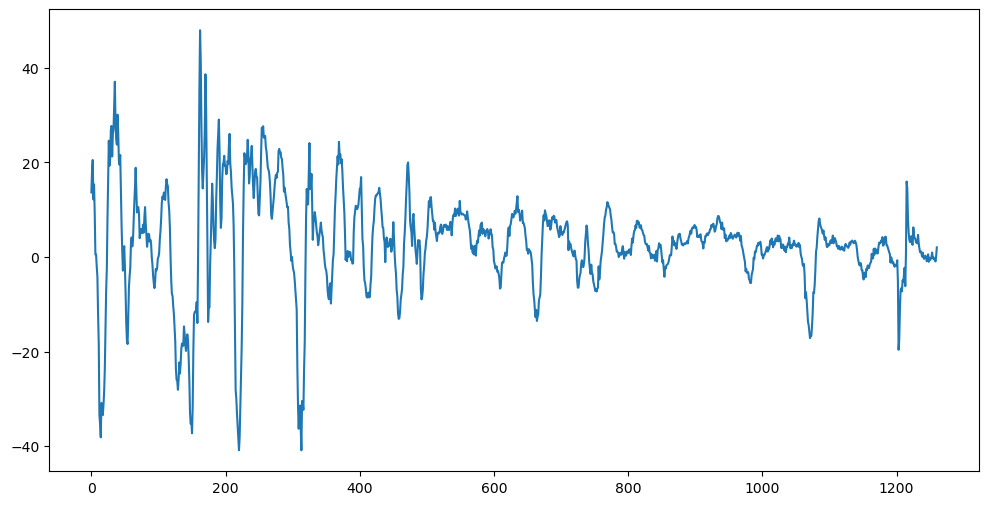

In [16]:
pind = prod_index['IPB50001N']
pind = pind.to_numpy()
y_diff = 100 * (np.log(pind[12:]) - np.log(pind[:-12]))

plt.figure(figsize = (12, 6))
plt.plot(y_diff)

n = len(y_diff)
print(n) # now n is odd

plt.show()

Now $n$ is odd. 

In [17]:
def spectrum_n_odd_estimator_ridge(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y) # Length of original time series

    alpha = cp.Variable(m)

    likelihood_term = cp.sum(cp.multiply((2 * I / n), cp.exp(-2 * alpha)) + 2 * alpha)
    smoothness_penalty = cp.sum(cp.square(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))

    objective = cp.Minimize(likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve()

    return alpha.value, freq # Return estimated log spectral density and frequencies

def spectrum_n_odd_estimator_lasso(y, lambda_val):
    freq, I = periodogram(y)
    m = len(freq)
    n = len(y) # Length of original time series

    alpha = cp.Variable(m)

    likelihood_term = cp.sum(cp.multiply((2 * I / n), cp.exp(-2 * alpha)) + 2 * alpha)
    smoothness_penalty = cp.sum(cp.abs(alpha[2:] - 2 * alpha[1:-1] + alpha[:-2]))

    objective = cp.Minimize(likelihood_term + lambda_val * smoothness_penalty)
    problem = cp.Problem(objective)
    problem.solve()

    return alpha.value, freq # Return estimated log spectral density and frequencies

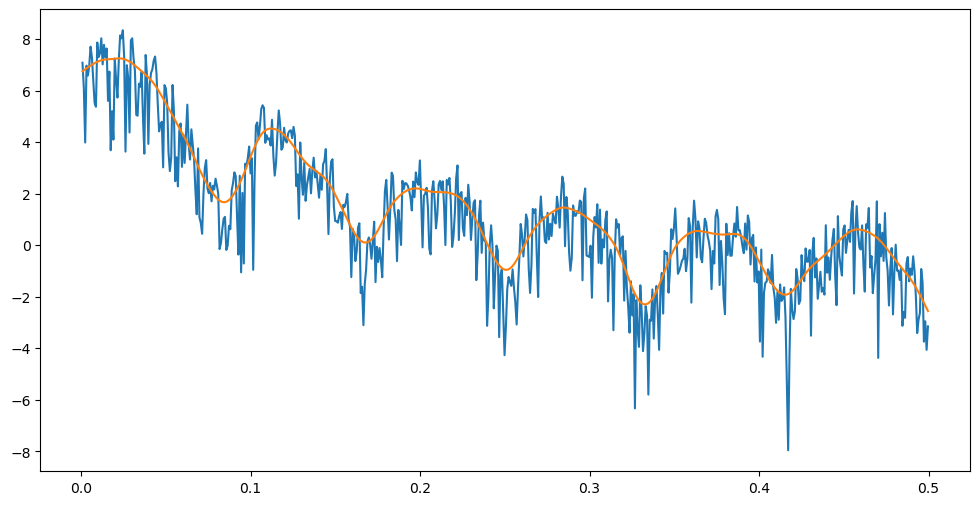

In [18]:
freq, pgram = periodogram(y_diff)
alpha_opt_ridge, freq = spectrum_n_odd_estimator_ridge(y_diff, 5000)
# I found lambda = 5000 is reasonable here
# Below we plot the log(periodogram) and the fitted spectrum estimator on the same plot
# This illustrates how the spectrum estimate can be viewed as a smoothing of the periodogram

plt.figure(figsize = (12, 6))
plt.plot(freq, np.log(pgram))
plt.plot(freq, np.log(n / 2) + 2 * alpha_opt_ridge)
plt.show()

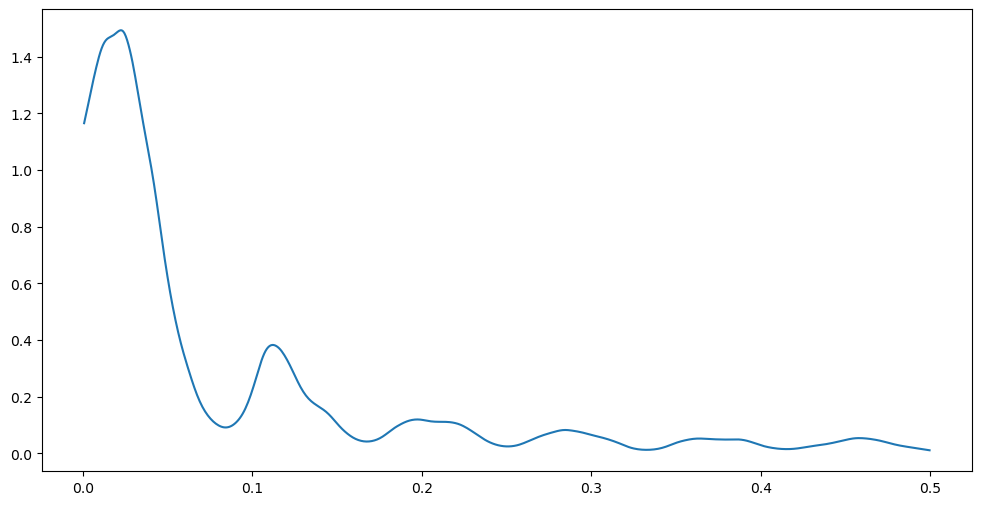

In [19]:
# Plotting the tau_j estimates (estimated spectrum):
tau_opt_ridge = np.exp(alpha_opt_ridge)

plt.figure(figsize = (12, 6))
plt.plot(freq, tau_opt_ridge)
plt.show()

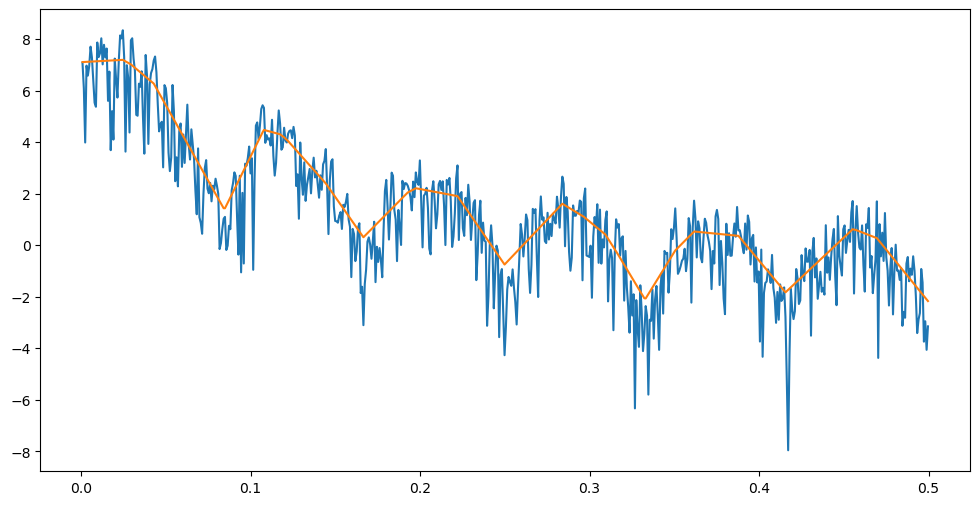

In [20]:
alpha_opt_lasso, freq = spectrum_n_odd_estimator_lasso(y_diff, 100)
# I found lambda = 100 is reasonable here
# Below we plot the log(periodogram) and the fitted spectrum estimator on the same plot
# This illustrates how the spectrum estimate can be viewed as a smoothing of the periodogram

plt.figure(figsize = (12, 6))
plt.plot(freq, np.log(pgram))
plt.plot(freq, np.log(n / 2) + 2 * alpha_opt_lasso)
plt.show()

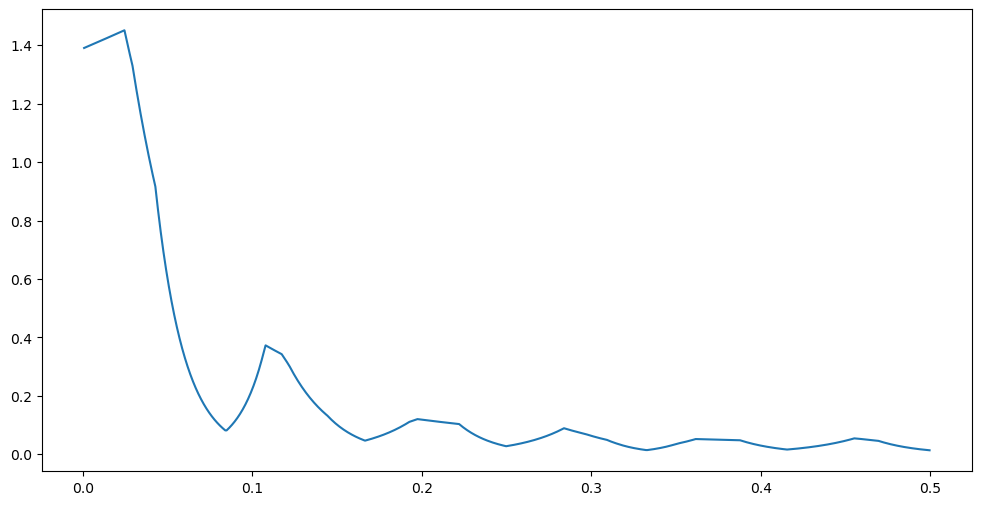

In [21]:
# Plotting the tau_j estimates (estimated spectrum):
tau_opt_lasso = np.exp(alpha_opt_lasso)

plt.figure(figsize = (12, 6))
plt.plot(freq, tau_opt_lasso)
plt.show()

In [22]:
# Find peaks in the estimated spectrum
peaks_ridge, _ = find_peaks(tau_opt_ridge)
peak_ridge_freqs = peaks_ridge / n
gaps_ridge = np.diff(peaks_ridge)

print("Peak frequencies:", peak_ridge_freqs)
print("Peak periods:", 1 / peak_ridge_freqs)
print("Gaps between peaks:", gaps_ridge)

Peak frequencies: [0.02141158 0.111023   0.19666931 0.2109437  0.28390167 0.36320381
 0.38382236 0.45757335]
Peak periods: [46.7037037   9.00714286  5.08467742  4.7406015   3.52234637  2.75327511
  2.6053719   2.18544194]
Gaps between peaks: [113 108  18  92 100  26  93]


Now the main peak is for the business cycle which corresponds to a period of close to 4 years. The other peaks are much smaller.

In [23]:
# Find peaks in the estimated spectrum
peaks_lasso, _ = find_peaks(tau_opt_lasso)
peak_lasso_freqs = peaks_lasso / n
gaps_lasso = np.diff(peaks_lasso)

print("Peak frequencies:", peak_lasso_freqs)
print("Peak periods:", 1 / peak_lasso_freqs)
print("Gaps between peaks:", gaps_lasso)

Peak frequencies: [0.02379064 0.10705789 0.19666931 0.28310864 0.36082474 0.45440127]
Peak periods: [42.03333333  9.34074074  5.08467742  3.53221289  2.77142857  2.20069808]
Gaps between peaks: [105 113 109  98 118]


Please read Section 6.4 of the Hamilton book for more on the interpretation of these spectral estimates. 